## 군집 특성 추론

데이터 로드

In [1]:
import pandas as pd

pca_result = pd.read_csv('./data/minmax_scaling_PCA_label.csv', index_col=0)
scaled_df = pd.read_csv('./data/minmax_scaling.csv', index_col=0)
original_df = pd.read_csv('./data/final_data_after_winsorization.csv', index_col=0)

### 1. boxplot으로 시각화해서 각 군집의 특성을 추론하기

In [2]:
# 시각화 폰트 깨지는 오류 디버깅
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import os

# 운영체제별 한글 폰트 설정
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

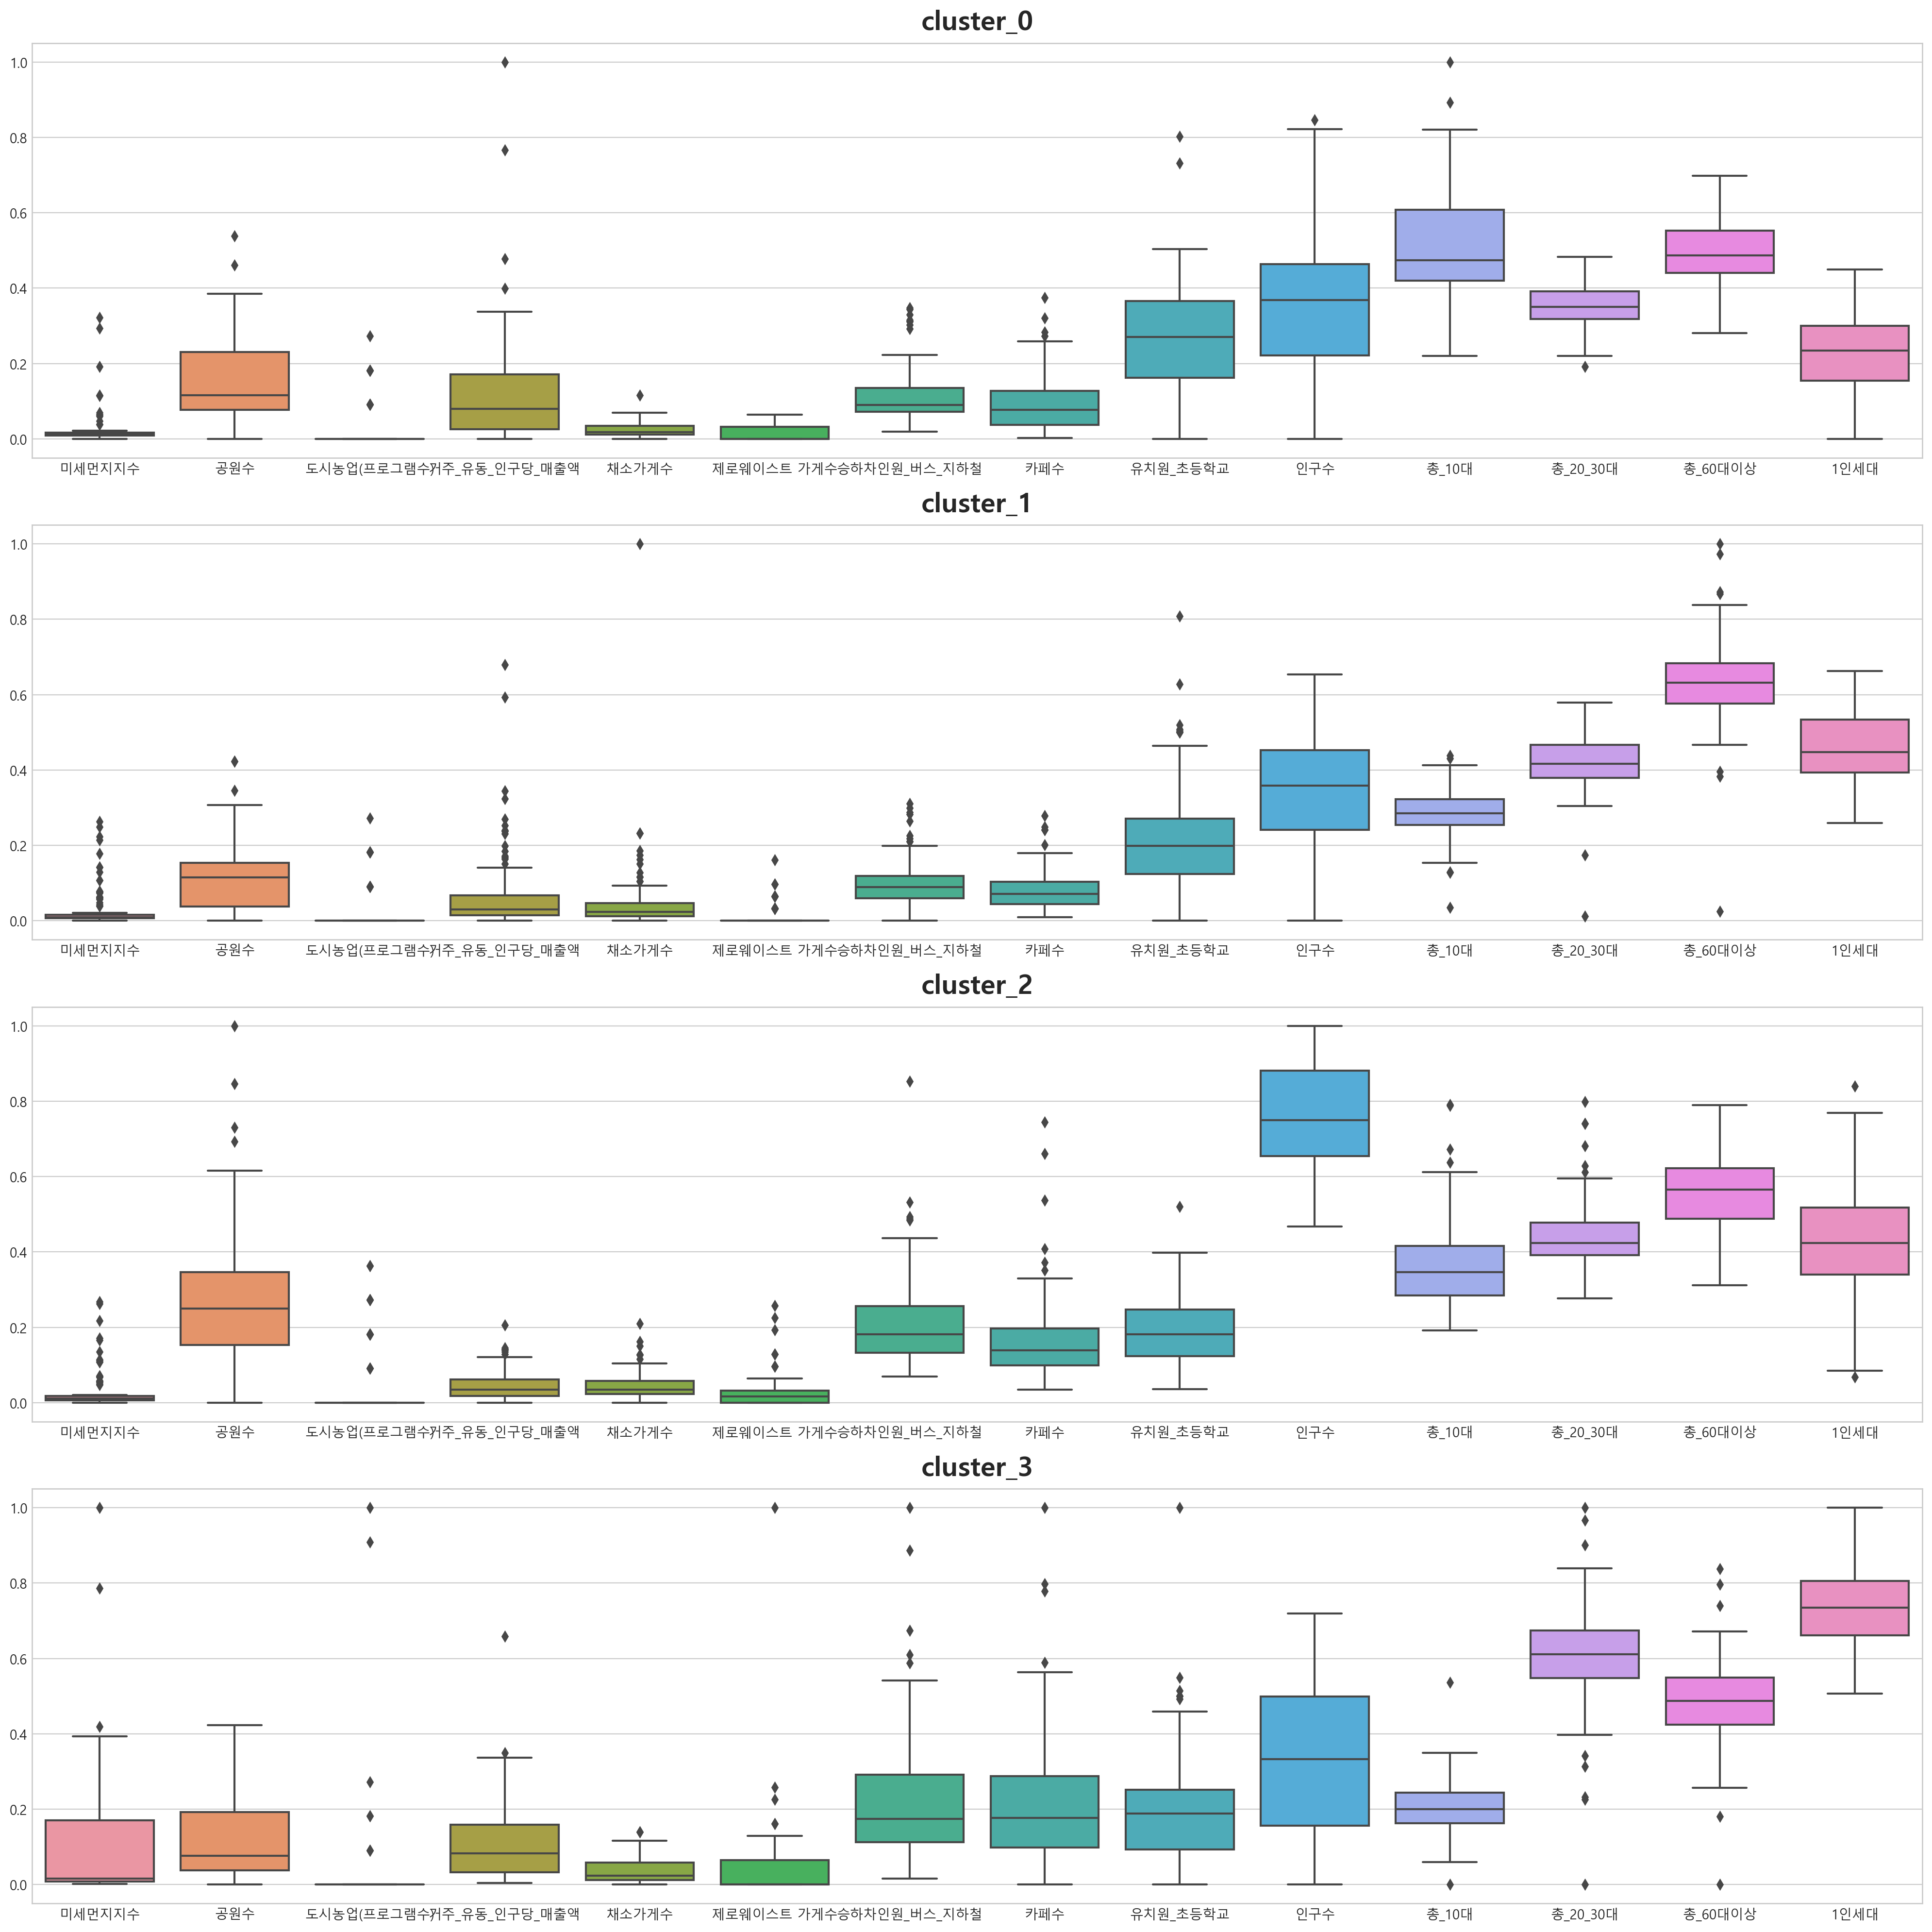

In [3]:
import seaborn as sns

fig , axes = plt.subplots(nrows=4 ,ncols=1,
                          figsize=(20,20) )
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, 
                    top=0.99, wspace=None, hspace=0.2)
ax = axes.flatten()

for i in range(len(pca_result['cluster'].unique())):
    sns.boxplot(data=scaled_df.loc[pca_result[pca_result['cluster'] == i].index, :], ax = ax[i])
    ax[i].set_title(f"cluster_{i}", fontsize= 20)

plt.show()

### 2. parallel_coordinates로 시각화해서 각 군집의 특성 추론하기

In [4]:
# minmax scaled data에 클러스터링 레이블 컬럼 추가
scaled_df_label = pd.concat([scaled_df.loc[pca_result[pca_result['cluster'] == i].index, :]
    for i in range(len(pca_result['cluster'].unique()))])

scaled_df_label = scaled_df_label.join(pca_result['cluster'], on='행정동명')
scaled_df_label.sample(3)

미세먼지지수       공원수  도시농업(프로그램수)  거주_유동_인구당_매출액     채소가게수  제로웨이스트 가게수  \
행정동명                                                                         
성현동   0.016148  0.000000          0.0       0.000440  0.023256    0.000000   
중계1동  0.008654  0.192308          0.0       0.067804  0.000000    0.032258   
중화1동  0.011530  0.038462          0.0       0.021454  0.023256    0.032258   

      승하차인원_버스_지하철       카페수  유치원_초등학교       인구수     총_10대  총_20_30대  \
행정동명                                                                   
성현동       0.143587  0.036946  0.202002  0.665746  0.417539  0.372904   
중계1동      0.108773  0.093596  0.174355  0.607666  0.892079  0.268136   
중화1동      0.080013  0.046798  0.425161  0.399866  0.278704  0.430822   

       총_60대이상      1인세대  cluster  
행정동명                               
성현동   0.595174  0.349453        2  
중계1동  0.333270  0.116828        0  
중화1동  0.656656  0.417612        1

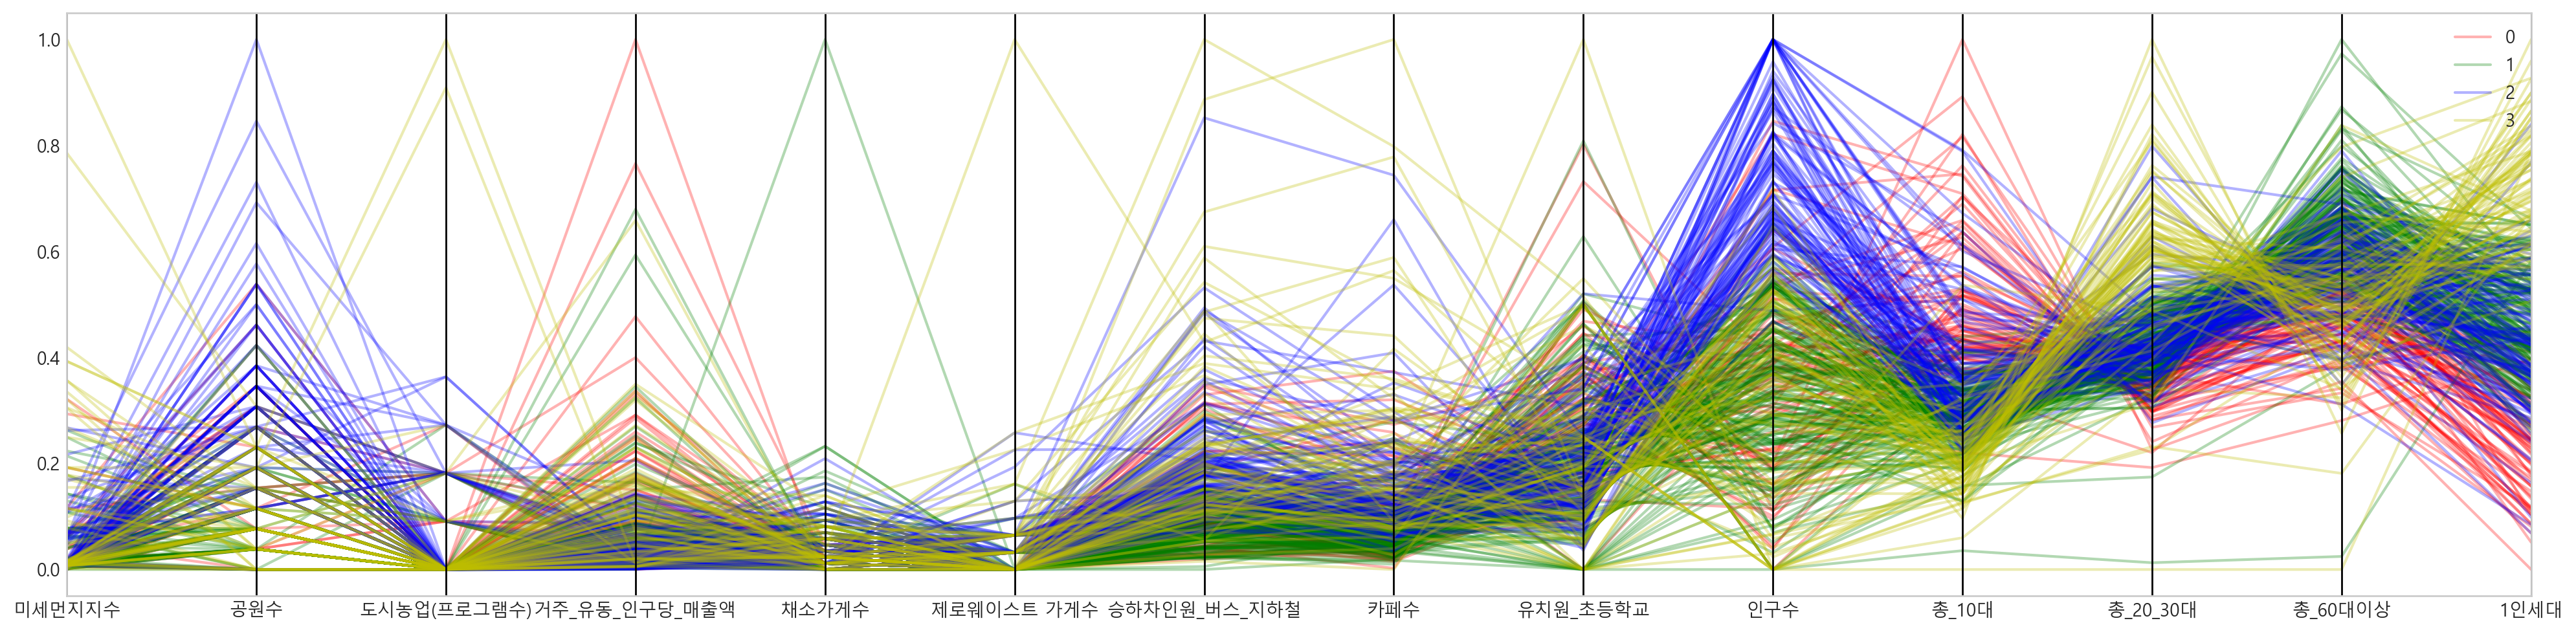

In [5]:
from pandas.plotting import parallel_coordinates
plt.figure(figsize=(20,5))
parallel_coordinates(scaled_df_label, class_column='cluster', 
                     cols=scaled_df_label.drop('cluster', axis=1).columns, 
                     color=['r', 'g', 'b', 'y'], alpha=0.3)
plt.show()

### 3. RandomForest 모델링을 통해 군집의 특성 추론하기

-  raw data 활용

In [6]:
# feature selection을 통해 필터링한 컬럼
features = ['미세먼지지수', '공원수', '도시농업(프로그램수)', '거주_유동_인구당_매출액', '채소가게수', '제로웨이스트 가게수',
       '승하차인원_버스_지하철', '카페수', '유치원_초등학교', '인구수', '총_10대', '총_20_30대',
       '총_60대이상', '1인세대']

In [7]:
# original data에 클러스터링 레이블 컬럼 추가
original_df_label = pd.concat([original_df.loc[pca_result[pca_result['cluster'] == i].index, :]
    for i in range(len(pca_result['cluster'].unique()))])

original_df_label = original_df_label[features]
original_df_label = original_df_label.join(pca_result['cluster'], on='행정동명')
original_df_label.sample(3)

미세먼지지수  공원수  도시농업(프로그램수)  거주_유동_인구당_매출액  채소가게수  제로웨이스트 가게수  \
행정동명                                                               
인헌동   17.205    5          0.0      22.543848   12.0         0.0   
공릉1동  15.673    8          0.0      80.254290    7.0         2.0   
대치2동  16.560    3          0.0     210.211256    3.0         1.0   

      승하차인원_버스_지하철   카페수  유치원_초등학교    인구수     총_10대  총_20_30대   총_60대이상  \
행정동명                                                                      
인헌동       202482.0  32.0  0.000039  51444  0.053223  0.425628  0.226227   
공릉1동      296420.0  81.0  0.000124  72480  0.069233  0.320088  0.278146   
대치2동      619306.0  87.0  0.000081  37026  0.170610  0.198347  0.211824   

          1인세대  cluster  
행정동명                     
인헌동   0.608874        3  
공릉1동  0.511409        2  
대치2동  0.200912        0

In [8]:
# randomforest classification을 위한 데이터 준비
original_df_label['binary_cluster_0'] = original_df_label['cluster'].map({0:1, 1:0, 2:0, 3:0})
original_df_label['binary_cluster_1'] = original_df_label['cluster'].map({0:0, 1:1, 2:0, 3:0})
original_df_label['binary_cluster_2'] = original_df_label['cluster'].map({0:0, 1:0, 2:1, 3:0})
original_df_label['binary_cluster_3'] = original_df_label['cluster'].map({0:0, 1:0, 2:0, 3:1})
original_df_label.sample(3)

미세먼지지수  공원수  도시농업(프로그램수)  거주_유동_인구당_매출액  채소가게수  제로웨이스트 가게수  \
행정동명                                                               
면목7동  14.243    1          0.0      17.152537    8.0         0.0   
독산1동  14.245    8          2.0      27.797435    3.0         1.0   
상계5동  14.719    1          0.0      12.952898    5.0         2.0   

      승하차인원_버스_지하철   카페수  유치원_초등학교    인구수     총_10대  총_20_30대   총_60대이상  \
행정동명                                                                      
면목7동      223926.0  29.0  0.000047  42812  0.051201  0.283986  0.308932   
독산1동      695982.0  69.0  0.000099  80894  0.058546  0.453161  0.236730   
상계5동      153208.0  40.0  0.000043  46594  0.076276  0.241104  0.322788   

          1인세대  cluster  binary_cluster_0  binary_cluster_1  binary_cluster_2  \
행정동명                                                                            
면목7동  0.453404        1                 0                 1                 0   
독산1동  0.553923        2                 0                 0                 1   
상계5동  0.406881        1                 0                 1                 0   

      binary_cluster_3  
행정동명                    
면목7동                 0  
독산1동                 0  
상계5동                 0

In [9]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def check_feature_importance(df, col):
    clf = RandomForestClassifier(random_state=1)
    clf.fit(df.iloc[:, :-5].values, df[col].values)

    # 가장 중요한 피처의 인덱스 구하기
    sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1] # Reverse sort

    # 가장 중요한 피처의 이름과 weight 구하기
    most_important_features = np.take_along_axis(
        np.array(df.iloc[:, 0:-1].columns.tolist()), 
        sorted_feature_weight_idxes, axis=0)
    most_important_weights = np.take_along_axis(
        np.array(clf.feature_importances_), 
        sorted_feature_weight_idxes, axis=0)

    result = list(zip(most_important_features, most_important_weights))
    return pd.DataFrame(index=most_important_features, data=most_important_weights, columns=['feature importance'])

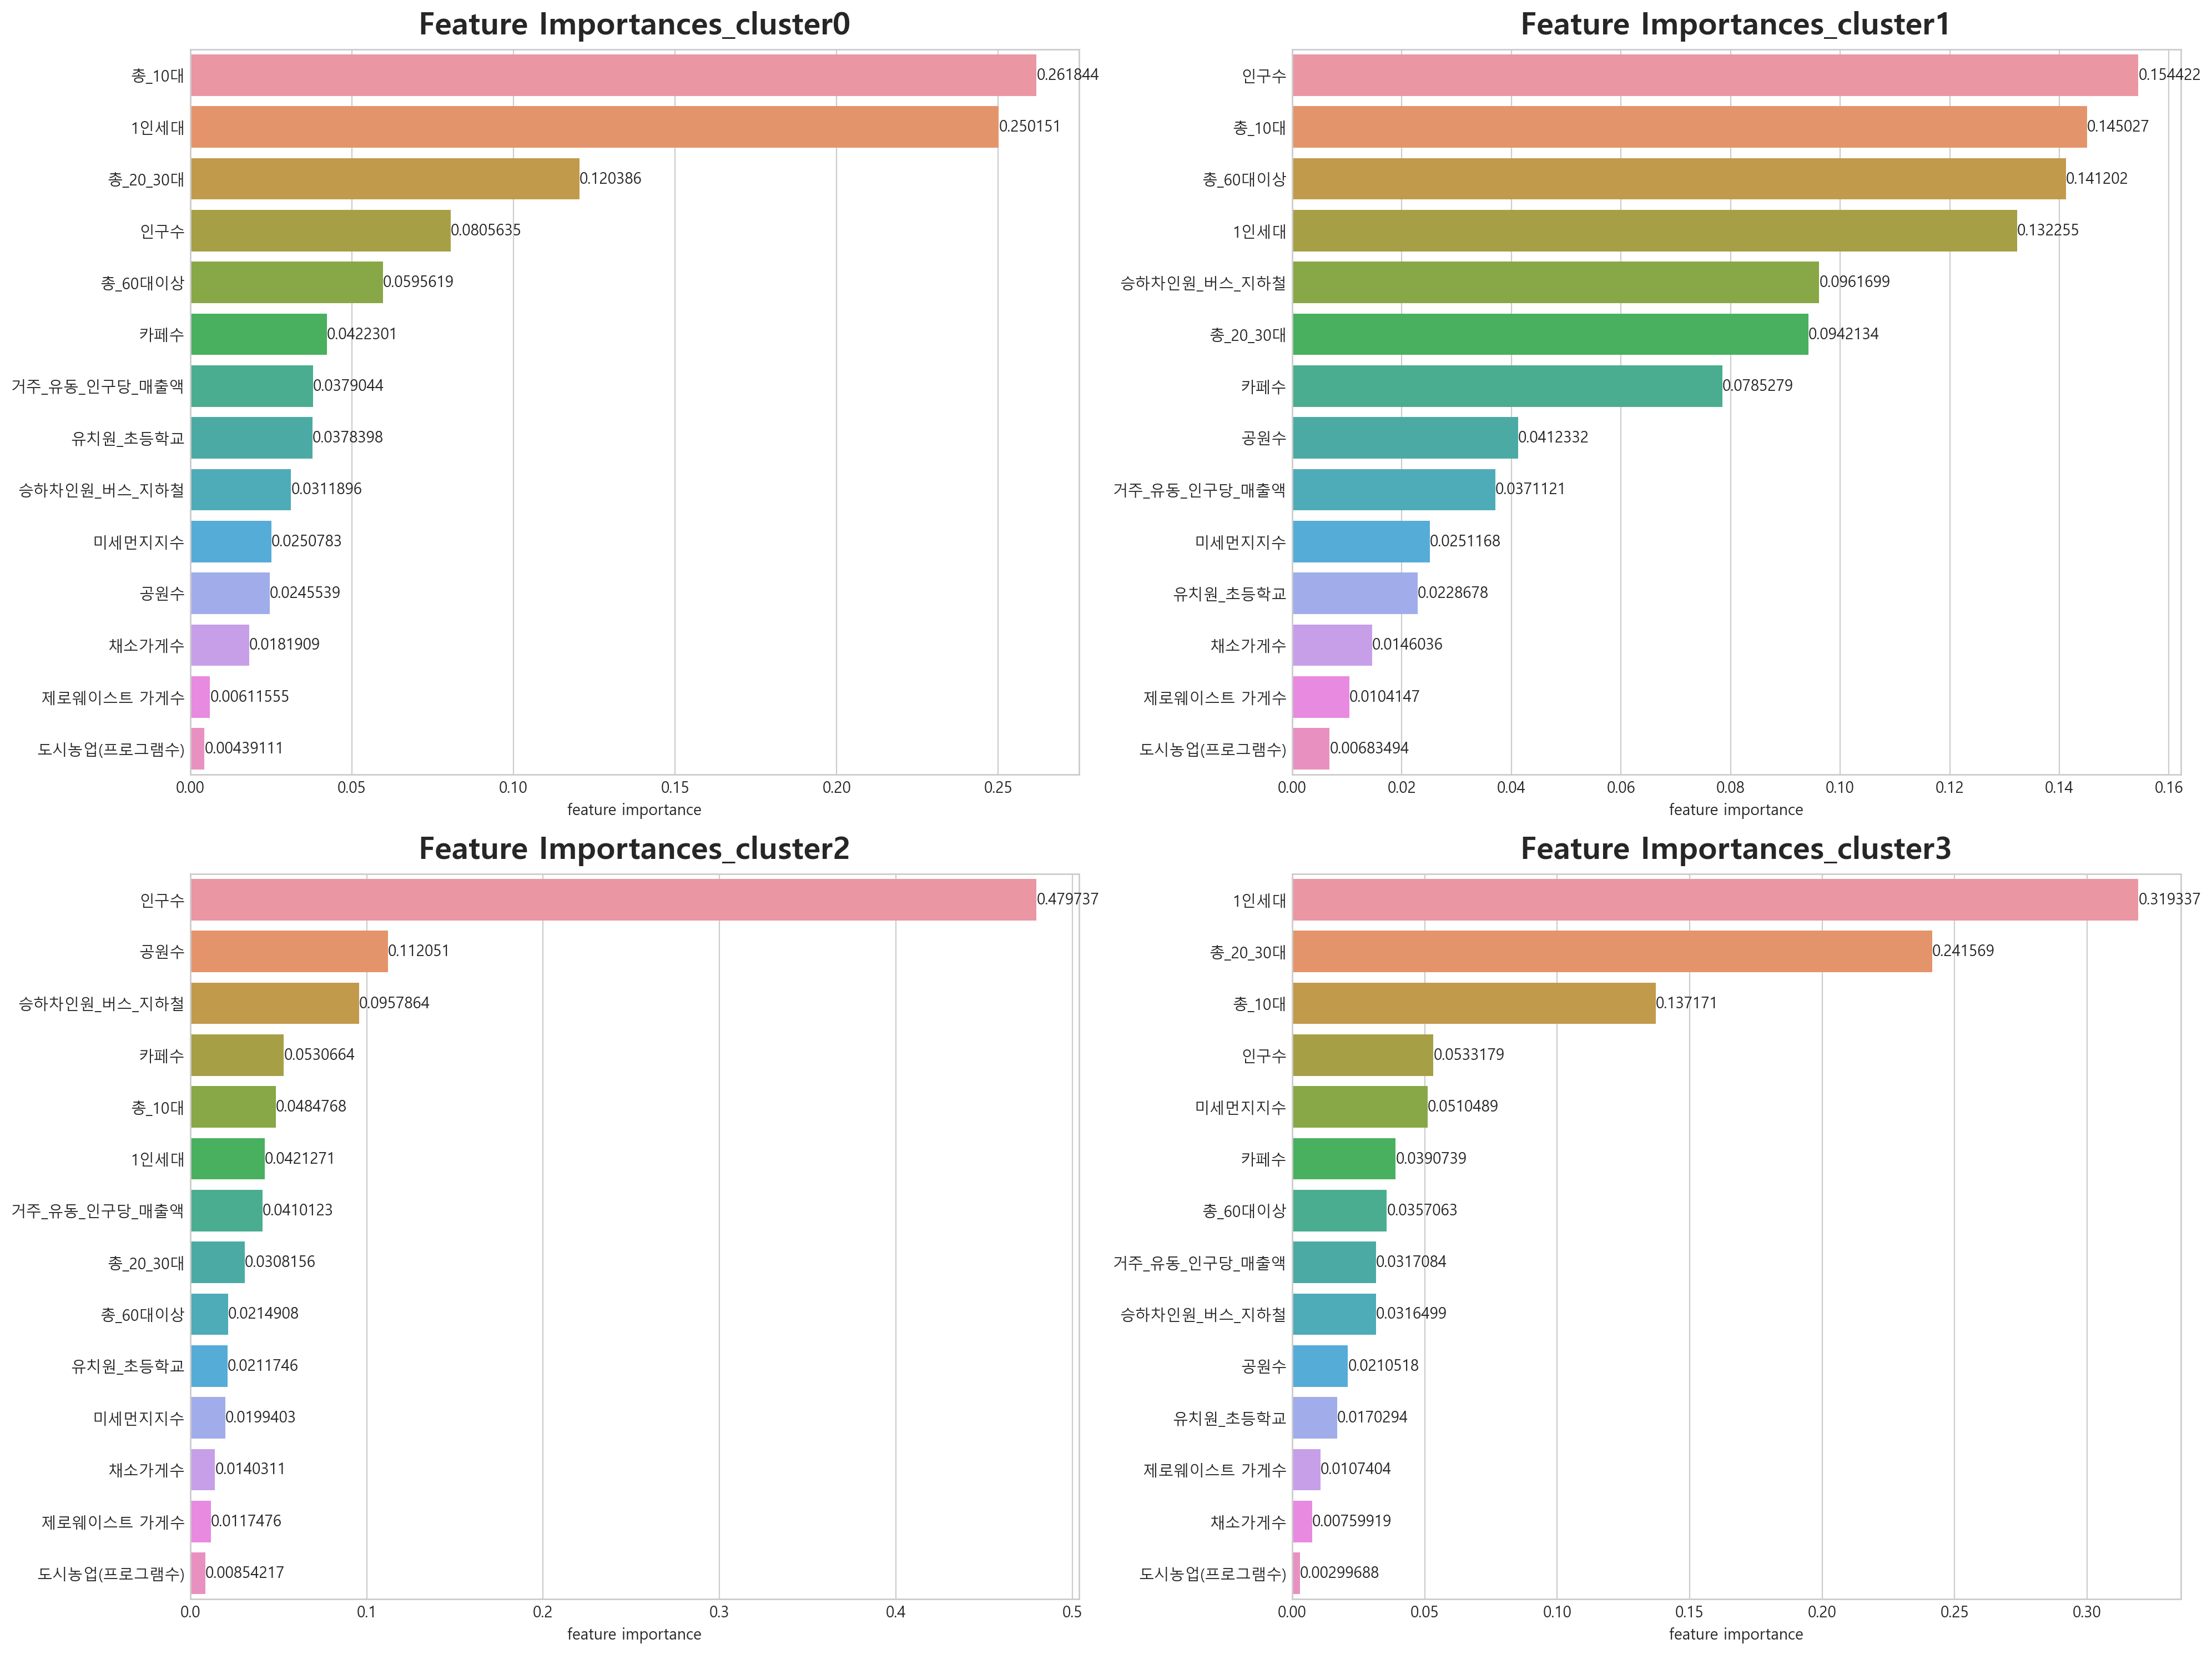

In [10]:
fig, axes = plt.subplots(nrows=2 ,ncols=2,
                          figsize=(20,15))
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, 
                    top=0.99, wspace=None, hspace=0.2)
ax = axes.flatten()

for i in range(len(pca_result['cluster'].unique())):
    sns.barplot(x=check_feature_importance(original_df_label, f'binary_cluster_{i}')['feature importance'], 
            y=check_feature_importance(original_df_label, f'binary_cluster_{i}').index, ax=ax[i])
    ax[i].set_title(f"Feature Importances_cluster{i}", fontsize= 20)
    ax[i].bar_label(ax[i].containers[0], fontsize=10);

plt.show()

- minmax scaled data 활용

In [11]:
# randomforest classification을 위한 데이터 준비
scaled_df_label['binary_cluster_0'] = scaled_df_label['cluster'].map({0:1, 1:0, 2:0, 3:0})
scaled_df_label['binary_cluster_1'] = scaled_df_label['cluster'].map({0:0, 1:1, 2:0, 3:0})
scaled_df_label['binary_cluster_2'] = scaled_df_label['cluster'].map({0:0, 1:0, 2:1, 3:0})
scaled_df_label['binary_cluster_3'] = scaled_df_label['cluster'].map({0:0, 1:0, 2:0, 3:1})
scaled_df_label.sample(3)

미세먼지지수       공원수  도시농업(프로그램수)  거주_유동_인구당_매출액     채소가게수  제로웨이스트 가게수  \
행정동명                                                                         
필동    0.357142  0.038462     0.000000       0.177094  0.011628    0.064516   
행당2동  0.006927  0.153846     0.000000       0.089527  0.023256    0.000000   
연희동   0.006017  0.346154     0.090909       0.046252  0.023256    0.193548   

      승하차인원_버스_지하철       카페수  유치원_초등학교       인구수     총_10대  총_20_30대  \
행정동명                                                                   
필동        0.099713  0.184729  1.000000  0.000000  0.189457  0.460964   
행당2동      0.080567  0.027094  0.150091  0.512902  0.368911  0.396705   
연희동       0.531516  0.298030  0.067265  0.825536  0.275505  0.571281   

       총_60대이상      1인세대  cluster  binary_cluster_0  binary_cluster_1  \
행정동명                                                                    
필동    0.555472  0.763791        3                 0                 0   
행당2동  0.547356  0.243387        0                 1                 0   
연희동   0.526514  0.630091        2                 0                 0   

      binary_cluster_2  binary_cluster_3  
행정동명                                      
필동                   0                 1  
행당2동                 0                 0  
연희동                  1                 0

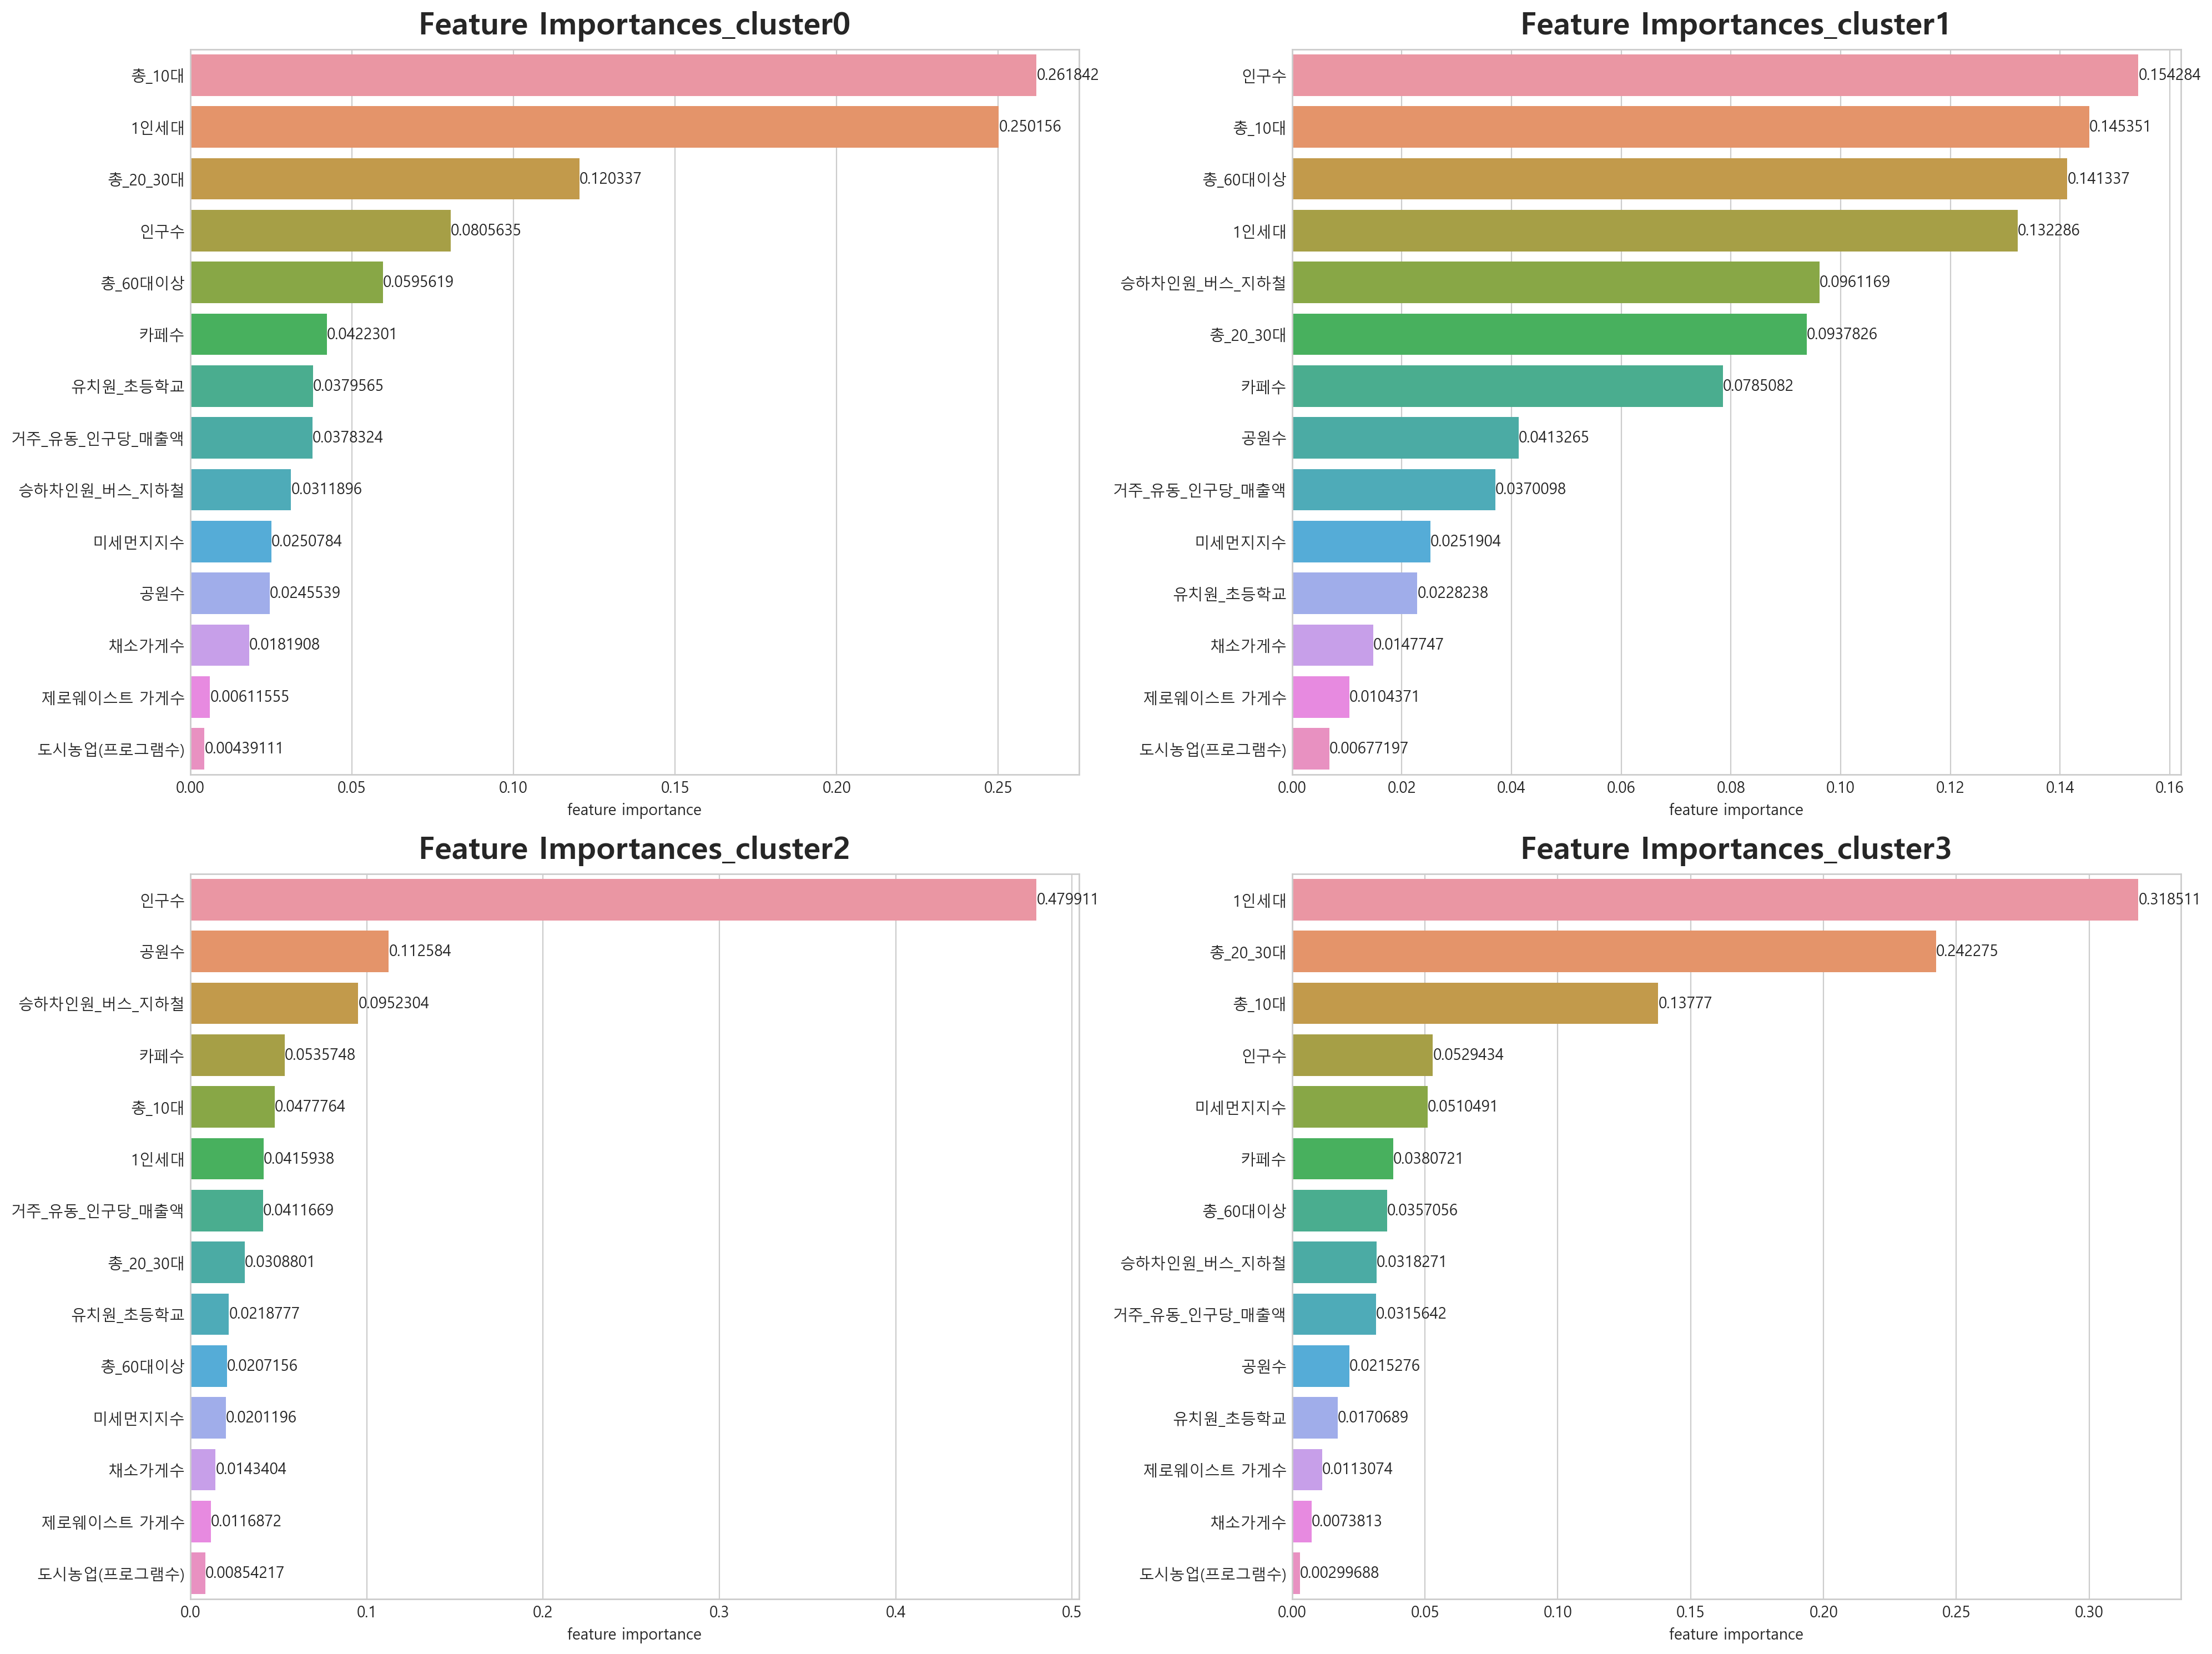

In [12]:
fig, axes = plt.subplots(nrows=2 ,ncols=2,
                          figsize=(20,15))
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, 
                    top=0.99, wspace=None, hspace=0.2)
ax = axes.flatten()

for i in range(len(pca_result['cluster'].unique())):
    sns.barplot(x=check_feature_importance(scaled_df_label, f'binary_cluster_{i}')['feature importance'], 
            y=check_feature_importance(scaled_df_label, f'binary_cluster_{i}').index, ax=ax[i])
    ax[i].set_title(f"Feature Importances_cluster{i}", fontsize= 20)
    ax[i].bar_label(ax[i].containers[0], fontsize=10);

plt.show()

### 4. 서울시 평균과 클러스터별 평균을 비교해서 군집 특성 파악

In [13]:
# minmax scaled data 불러와서 cluster label 붙이기
scaled_df = pd.read_csv('./data/minmax_scaling.csv', index_col=0)
if scaled_df.index.equals(pca_result.index):
    tmp = scaled_df.copy()
    tmp['cluster'] = pca_result['cluster']
tmp.head(2)

미세먼지지수       공원수  도시농업(프로그램수)  거주_유동_인구당_매출액     채소가게수  제로웨이스트 가게수  \
행정동명                                                                         
가락1동  0.014204  0.076923          0.0       0.025989  0.116279         0.0   
가락2동  0.014204  0.346154          0.0       0.035016  0.034884         0.0   

      승하차인원_버스_지하철       카페수  유치원_초등학교       인구수     총_10대  총_20_30대  \
행정동명                                                                   
가락1동      0.085682  0.105911  0.125300  0.639775  0.426207  0.408414   
가락2동      0.088504  0.182266  0.220257  0.745585  0.466991  0.415310   

       총_60대이상      1인세대  cluster  
행정동명                               
가락1동  0.457904  0.112284        0  
가락2동  0.489702  0.269226        2

In [14]:
# 클러스터별로 따로 데이터프레임 만들기
scaled_cluster_0 = tmp[tmp['cluster'] == 0].drop('cluster', axis=1)
scaled_cluster_1 = tmp[tmp['cluster'] == 1].drop('cluster', axis=1)
scaled_cluster_2 = tmp[tmp['cluster'] == 2].drop('cluster', axis=1)
scaled_cluster_3 = tmp[tmp['cluster'] == 3].drop('cluster', axis=1)

# 서울시 전체 평균 + 각 클러스터별 평균 합친 버전
scaled_result = pd.DataFrame([scaled_df.mean(), scaled_cluster_0.mean(), scaled_cluster_1.mean(), scaled_cluster_2.mean(), scaled_cluster_3.mean()], index = ['서울시 전체', 'scaled_cluster0', 'scaled_cluster1', 'scaled_clutser2', 'scaled_cluster3'])
scaled_result

미세먼지지수       공원수  도시농업(프로그램수)  거주_유동_인구당_매출액     채소가게수  \
서울시 전체           0.041083  0.162784     0.023901       0.077117  0.038678   
scaled_cluster0  0.027505  0.157389     0.023923       0.127592  0.022338   
scaled_cluster1  0.023666  0.117775     0.010786       0.058712  0.041913   
scaled_clutser2  0.032206  0.281154     0.036364       0.046434  0.044419   
scaled_cluster3  0.109606  0.115385     0.038605       0.111226  0.039981   

                 제로웨이스트 가게수  승하차인원_버스_지하철       카페수  유치원_초등학교       인구수  \
서울시 전체             0.020521      0.152383  0.127778  0.218402  0.440374   
scaled_cluster0    0.010611      0.118819  0.097809  0.273914  0.359629   
scaled_cluster1    0.008383      0.097860  0.079527  0.214019  0.345865   
scaled_clutser2    0.030968      0.213712  0.165640  0.193669  0.763118   
scaled_cluster3    0.045957      0.235512  0.224104  0.205114  0.311474   

                    총_10대  총_20_30대   총_60대이상      1인세대  
서울시 전체           0.332697  0.445560  0.565364  0.458104  
scaled_cluster0  0.516109  0.351139  0.496944  0.228707  
scaled_cluster1  0.285187  0.420920  0.633986  0.463607  
scaled_clutser2  0.370675  0.444657  0.555086  0.420316  
scaled_cluster3  0.204914  0.604845  0.484293  0.735352

In [15]:
# 서울시 평균, cluster_0의 평균
compared_cluster_0 = pd.DataFrame([scaled_df.mean(), 
            scaled_cluster_0.mean()], 
            index = ['서울시 전체', 'scaled_cluster0']).T

compared_cluster_1 = pd.DataFrame([scaled_df.mean(), 
            scaled_cluster_1.mean()], 
            index = ['서울시 전체', 'scaled_cluster1']).T

compared_cluster_2 = pd.DataFrame([scaled_df.mean(), 
            scaled_cluster_2.mean()], 
            index = ['서울시 전체', 'scaled_cluster2']).T

compared_cluster_3 = pd.DataFrame([
            scaled_df.mean(), 
            scaled_cluster_3.mean()], 
            index = ['서울시 전체', 'scaled_cluster3']).T

In [16]:
# pd.melt를 활용해서 df_melted 데이터프레임 생성 -> grouped bar charat 생성하기 위해서
def create_df_melted(df):
    df_melted = pd.melt(
        df.reset_index(), 
        id_vars='index', 
        value_vars= df.columns, 
        var_name='종류', value_name='Value')
    return df_melted

In [17]:
# 차트에 나타내기에 인덱스 문장 길이가 길다 -> grouped bar chart에 표시할 xlabel 이름 짧게 재지정 
modified_index = ['미세먼지지수', '공원수', '도시농업', '매출액', '채소가게수', '제로웨이스트가게수',
       '승하차인원', '카페수', '유치원,초등학교', '인구수', '10대', '2030대',
       '60대이상', '1인세대']

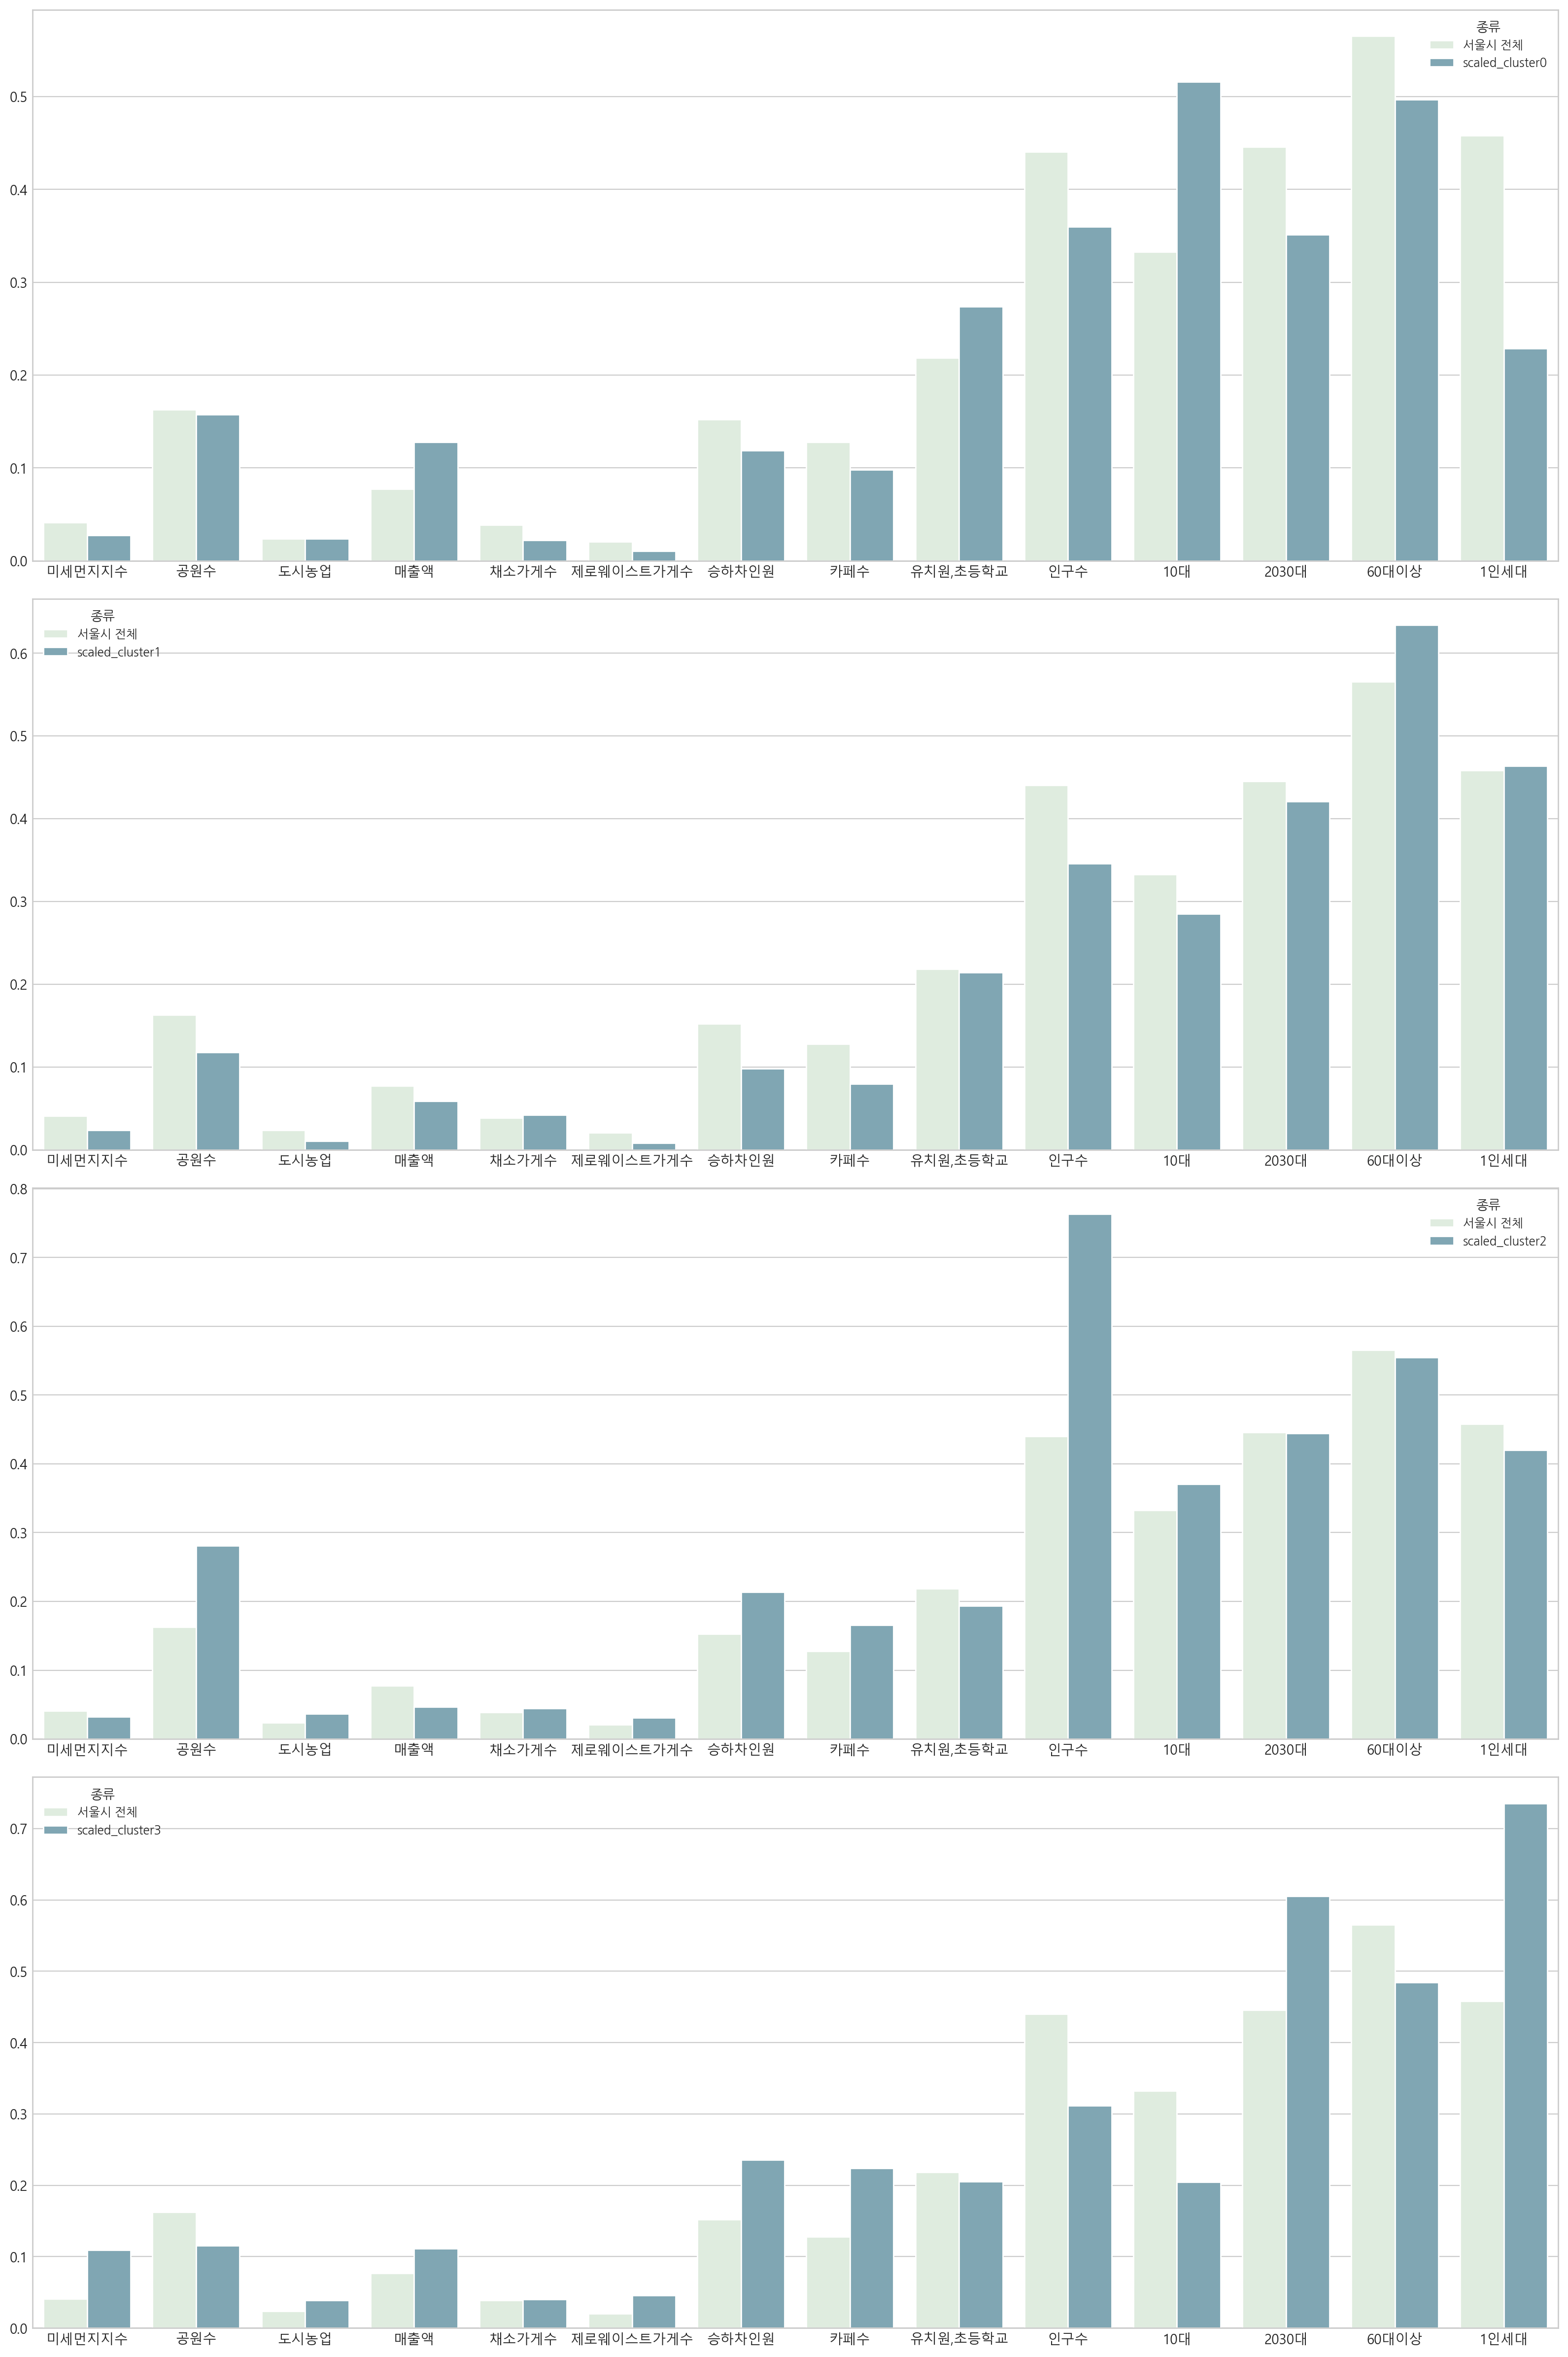

In [18]:
# 서울시 평균 vs cluster_0의 평균 시각화
import matplotlib.pyplot as plot
import seaborn as sns

df_list = [create_df_melted(i) for i in [compared_cluster_0, compared_cluster_1, compared_cluster_2, compared_cluster_3]]

fig, ax = plt.subplots(4, 1, figsize=(16, 24))
sns.set(style="whitegrid", font='NanumGothic', font_scale=0.8)

for idx, df in enumerate(df_list):
    ax_idx = sns.barplot(x="index", y="Value", hue="종류", data=df, palette="blend:#DED,#7AB", ax=ax[idx])
    ax_idx.set(xlabel=None, ylabel=None)
    ax_idx.set_xticklabels(modified_index)
plt.xticks(rotation=0) 
plt.show()

- 서울시 평균 대비 두드러지는 특성

cluster_0 : 거주 인구수 대비 유치원 초등학교 수, 거주 인구수 대비 10대 인구   
clsuter_1 : 거주 인구수 대비 60대 인구, 채소가게 수  
cluster_2 : 총 인구수, 공원수   
cluster_3 : 총 세대 대비 1인 세대 비율, 거주 인구수 대비 2030대, 일 평균 대중교통 승하차인원  